In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [5]:
# ==================== MODEL DEFINITION ====================
def media_trust_ode(t, y, params):
    """
    ODE system for media trust model
    y = [S, E, T, D]
    """
    S, E, T, D = y
    
    # Parameters
    beta = params['beta']      # baseline exposure
    sigma = params['sigma']    # processing rate
    alpha = params['alpha']    # institutional reinforcement
    delta = params['delta']    # trust decay
    mu = params['mu']          # distrust recovery
    psi = params['psi']        # echo chamber effect
    
    
    # Theta function (can be time-dependent)
    if callable(params['theta']):
        theta_t = params['theta'](t)
    else:
        theta_t = params['theta']
    
    # ODE system (equations 1-4 from your paper)
    dS_dt = -(beta + alpha) * S + delta * T + mu * D
    dE_dt = beta * S + psi * D * S - sigma * E
    dT_dt = (1 - theta_t) * sigma * E + alpha * S - delta * T
    dD_dt = theta_t * sigma * E - mu * D
    
    return [dS_dt, dE_dt, dT_dt, dD_dt]

In [6]:
# ==================== OECD-BASED PARAMETERS ====================
def get_country_params(country_trust, country_name="Generic"):
    """
    Generate plausible parameters based on OECD trust levels
    country_trust: Trust percentage (e.g., 0.50 for 50%)
    """
    # Base parameters (will be scaled by trust level)
    base_params = {
        'beta': 0.3,    # baseline exposure rate
        'sigma': 0.4,   # processing rate
        'alpha': 0.05,  # institutional reinforcement
        'delta': 0.1,   # trust decay rate
        'mu': 0.02,     # distrust recovery (slow!)
        'psi': 0.15,    # echo chamber effect
        'theta': 0.3    # baseline distrust probability
    }
    
    # Adjust based on trust level
    # High trust countries: lower theta, higher alpha
    # Low trust countries: higher theta, lower alpha
    trust_factor = country_trust
    
    params = base_params.copy()
    params['theta'] = 0.4 - 0.2 * trust_factor  # Inverse relationship
    params['alpha'] = 0.02 + 0.06 * trust_factor  # Direct relationship
    
    print(f"\n{country_name} parameters (trust={100*country_trust:.1f}%):")
    print(f"  θ₀ = {params['theta']:.3f}")
    print(f"  α = {params['alpha']:.3f}")
    
    return params

In [7]:


# ==================== SCENARIO 1: EQUILIBRIUM ANALYSIS ====================
def scenario_equilibrium():
    print("\n" + "="*60)
    print("SCENARIO 1: Equilibrium Analysis (Constant θ)")
    print("="*60)
    
    # Colombia (high trust) vs UK (low trust)
    colombia_params = get_country_params(0.637, "Colombia")
    uk_params = get_country_params(0.277, "United Kingdom")
    
    # Initial conditions: mostly neutral
    y0 = [0.8, 0.1, 0.05, 0.05]  # [S, E, T, D]
    
    # Time span (long enough to reach equilibrium)
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 1000)
    
    # Solve for both countries
    sol_col = solve_ivp(
        lambda t, y: media_trust_ode(t, y, colombia_params),
        t_span, y0, t_eval=t_eval, method='RK45'
    )
    
    sol_uk = solve_ivp(
        lambda t, y: media_trust_ode(t, y, uk_params),
        t_span, y0, t_eval=t_eval, method='RK45'
    )
    
    # Plot results
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, figure=fig)
    
    # Time series comparison
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(sol_col.t, sol_col.y[2], 'g-', linewidth=2, label='Colombia (T)')
    ax1.plot(sol_col.t, sol_col.y[3], 'r-', linewidth=2, label='Colombia (D)')
    ax1.plot(sol_uk.t, sol_uk.y[2], 'g--', linewidth=2, label='UK (T)')
    ax1.plot(sol_uk.t, sol_uk.y[3], 'r--', linewidth=2, label='UK (D)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population Share')
    ax1.set_title('Trust and Distrust Dynamics: Colombia vs UK')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Final equilibrium values
    ax2 = fig.add_subplot(gs[1, 0])
    countries = ['Colombia', 'UK']
    trust_eq = [sol_col.y[2, -1], sol_uk.y[2, -1]]
    distrust_eq = [sol_col.y[3, -1], sol_uk.y[3, -1]]
    
    x = np.arange(len(countries))
    width = 0.35
    
    ax2.bar(x - width/2, trust_eq, width, label='Trust (T)', color='green', alpha=0.7)
    ax2.bar(x + width/2, distrust_eq, width, label='Distrust (D)', color='red', alpha=0.7)
    ax2.set_xlabel('Country')
    ax2.set_ylabel('Equilibrium Share')
    ax2.set_title('Equilibrium Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(countries)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Parameter comparison
    ax3 = fig.add_subplot(gs[1, 1])
    params_to_plot = ['theta', 'alpha', 'mu']
    col_vals = [colombia_params[p] for p in params_to_plot]
    uk_vals = [uk_params[p] for p in params_to_plot]
    
    x = np.arange(len(params_to_plot))
    ax3.bar(x - 0.2, col_vals, 0.4, label='Colombia', alpha=0.7)
    ax3.bar(x + 0.2, uk_vals, 0.4, label='UK', alpha=0.7)
    ax3.set_xlabel('Parameter')
    ax3.set_ylabel('Value')
    ax3.set_title('Key Parameter Differences')
    ax3.set_xticks(x)
    ax3.set_xticklabels([r'$\theta_0$', r'$\alpha$', r'$\mu$'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('scenario1_equilibrium.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print equilibrium values
    print("\nEquilibrium Values:")
    print(f"Colombia: T* = {sol_col.y[2,-1]:.3f}, D* = {sol_col.y[3,-1]:.3f}")
    print(f"UK: T* = {sol_uk.y[2,-1]:.3f}, D* = {sol_uk.y[3,-1]:.3f}")


In [8]:

# ==================== SCENARIO 2: CRISIS SHOCK ====================
def scenario_crisis_shock():
    print("\n" + "="*60)
    print("SCENARIO 2: Crisis Shock (Temporary θ Spike)")
    print("="*60)
    
    # Use France as baseline (moderate trust)
    france_trust = 0.47
    params = get_country_params(france_trust, "France")
    
    # Time-dependent theta: crisis from t=20 to t=30
    def theta_with_crisis(t):
        theta_base = params['theta']
        if 20 <= t <= 30:
            # Crisis doubles distrust probability
            return min(0.9, theta_base * 2.5)
        return theta_base
    
    params_crisis = params.copy()
    params_crisis['theta'] = theta_with_crisis
    
    # Start at equilibrium (run baseline first to find it)
    y0 = [0.7, 0.1, 0.15, 0.05]
    t_span = (0, 100)
    
    # Solve baseline (no crisis)
    sol_baseline = solve_ivp(
        lambda t, y: media_trust_ode(t, y, params),
        (0, 20), y0, t_eval=np.linspace(0, 20, 200)
    )
    
    # Start crisis from equilibrium
    y0_crisis = sol_baseline.y[:, -1]
    sol_crisis = solve_ivp(
        lambda t, y: media_trust_ode(t, y, params_crisis),
        (20, 100), y0_crisis, t_eval=np.linspace(20, 100, 800)
    )
    
    # Combine solutions
    t_combined = np.concatenate([sol_baseline.t, sol_crisis.t])
    S_combined = np.concatenate([sol_baseline.y[0], sol_crisis.y[0]])
    T_combined = np.concatenate([sol_baseline.y[2], sol_crisis.y[2]])
    D_combined = np.concatenate([sol_baseline.y[3], sol_crisis.y[3]])
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Trust trajectory
    axes[0,0].plot(t_combined, T_combined, 'g-', linewidth=2, label='Trust (T)')
    axes[0,0].plot(t_combined, D_combined, 'r-', linewidth=2, label='Distrust (D)')
    axes[0,0].axvspan(20, 30, alpha=0.2, color='orange', label='Crisis period')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Population Share')
    axes[0,0].set_title('Trust Response to Crisis Shock')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Theta during crisis
    theta_vals = [theta_with_crisis(t) for t in t_combined]
    axes[0,1].plot(t_combined, theta_vals, 'b-', linewidth=2)
    axes[0,1].axvspan(20, 30, alpha=0.2, color='orange')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel(r'$\theta(t)$')
    axes[0,1].set_title('Interpretation Parameter During Crisis')
    axes[0,1].grid(True, alpha=0.3)
    
    # Recovery comparison
    trust_before = T_combined[np.abs(t_combined - 20).argmin()]
    trust_min = T_combined.min()
    trust_after = T_combined[-1]
    
    recovery_time = None
    for i, t in enumerate(t_combined):
        if t > 30 and T_combined[i] >= 0.95 * trust_before:
            recovery_time = t - 30
            break
    
    axes[1,0].bar(['Before', 'Minimum', 'After'], 
        [trust_before, trust_min, trust_after],
        color=['green', 'red', 'lightgreen'])
    axes[1,0].set_ylabel('Trust Level')
    axes[1,0].set_title(f'Trust Loss and Recovery\n(95% recovery in {recovery_time:.1f} time units)')
    axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # Phase portrait (T vs D)
    axes[1,1].plot(T_combined, D_combined, 'k-', linewidth=1, alpha=0.7)
    axes[1,1].scatter(T_combined[0], D_combined[0], s=100, c='blue', marker='o', label='Start', zorder=5)
    axes[1,1].scatter(T_combined[t_combined <= 20][-1],D_combined[t_combined <= 20][-1], s=100, c='orange', marker='s', label='Crisis start', zorder=5)
    axes[1,1].scatter(T_combined[t_combined >= 30][0], D_combined[t_combined >= 30][0], s=100, c='red', marker='^', label='Crisis end', zorder=5)
    axes[1,1].scatter(T_combined[-1], D_combined[-1], s=100, c='purple', marker='*', label='End', zorder=5)
    axes[1,1].set_xlabel('Trust (T)')
    axes[1,1].set_ylabel('Distrust (D)')
    axes[1,1].set_title('Phase Portrait: T vs D')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('scenario2_crisis_shock.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nCrisis Impact Analysis:")
    print(f"Trust before crisis: {trust_before:.3f}")
    print(f"Minimum trust during crisis: {trust_min:.3f}")
    print(f"Trust loss: {100*(trust_before-trust_min)/trust_before:.1f}%")
    print(f"Time to 95% recovery: {recovery_time:.1f} time units")


In [9]:

# ==================== SCENARIO 3: DISTRUST PERSISTENCE (μ) ====================
def scenario_distrust_persistence():
    print("\n" + "="*60)
    print("SCENARIO 3: Effect of Distrust Persistence (μ)")
    print("="*60)
    
    # Base parameters (USA-like)
    base_params = get_country_params(0.50, "USA")
    
    # Different μ values: fast vs slow recovery
    mu_values = [0.05, 0.02, 0.005]  # fast, medium, slow recovery
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    colors = ['green', 'orange', 'red']
    labels = ['Fast recovery (μ=0.05)', 'Medium (μ=0.02)', 'Slow (μ=0.005)']
    
    # Same crisis for all
    def theta_with_crisis(t):
        theta_base = 0.3
        if 20 <= t <= 30:
            return min(0.9, theta_base * 2.5)
        return theta_base
    
    for i, mu in enumerate(mu_values):
        params = base_params.copy()
        params['mu'] = mu
        params['theta'] = theta_with_crisis
        
        # Initial at equilibrium (run to t=20 first)
        y0 = [0.7, 0.1, 0.15, 0.05]
        
        # Get to equilibrium
        sol_pre = solve_ivp(
            lambda t, y: media_trust_ode(t, y, params),
            (0, 20), y0, t_eval=np.linspace(0, 20, 200)
        )
        
        # Continue through crisis
        y0_crisis = sol_pre.y[:, -1]
        sol_crisis = solve_ivp(
            lambda t, y: media_trust_ode(t, y, params),
            (20, 100), y0_crisis, t_eval=np.linspace(20, 100, 800)
        )
        
        # Combine
        t = np.concatenate([sol_pre.t, sol_crisis.t])
        T = np.concatenate([sol_pre.y[2], sol_crisis.y[2]])
        D = np.concatenate([sol_pre.y[3], sol_crisis.y[3]])
        
        # Plot trust recovery
        axes[0,0].plot(t, T, color=colors[i], linewidth=2, label=labels[i])
        axes[0,1].plot(t, D, color=colors[i], linewidth=2, label=labels[i])
    
    # Format trust plot
    axes[0,0].axvspan(20, 30, alpha=0.2, color='orange')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Trust (T)')
    axes[0,0].set_title('Trust Recovery for Different μ Values')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Format distrust plot
    axes[0,1].axvspan(20, 30, alpha=0.2, color='orange')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Distrust (D)')
    axes[0,1].set_title('Distrust Persistence for Different μ Values')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Recovery time analysis
    recovery_times = []
    final_trust_levels = []
    
    for mu in mu_values:
        params = base_params.copy()
        params['mu'] = mu
        params['theta'] = theta_with_crisis
        
        # Run full simulation
        sol = solve_ivp(
            lambda t, y: media_trust_ode(t, y, params),
            (0, 200), [0.7, 0.1, 0.15, 0.05], 
            t_eval=np.linspace(0, 200, 1000)
        )
        
        # Find recovery time (to within 5% of pre-crisis)
        pre_crisis_idx = np.abs(sol.t - 20).argmin()
        trust_pre = sol.y[2, pre_crisis_idx]
        
        recovery_idx = None
        for j in range(len(sol.t)):
            if sol.t[j] > 30 and sol.y[2, j] >= 0.95 * trust_pre:
                recovery_idx = j
                break
        
        if recovery_idx:
            recovery_times.append(sol.t[recovery_idx] - 30)
        else:
            recovery_times.append(200)  # never fully recovers
        
        final_trust_levels.append(sol.y[2, -1])
    
    # Bar chart: recovery time vs μ
    axes[1,0].bar([f'μ={mu}' for mu in mu_values], recovery_times, 
                  color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Recovery rate μ')
    axes[1,0].set_ylabel('Recovery Time (to 95% of pre-crisis)')
    axes[1,0].set_title('Distrust Persistence Effect on Recovery Time')
    axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # Scatter: μ vs equilibrium trust
    axes[1,1].plot(mu_values, final_trust_levels, 'bo-', linewidth=2, markersize=8)
    axes[1,1].set_xlabel('Recovery rate μ')
    axes[1,1].set_ylabel('Long-term Trust Equilibrium')
    axes[1,1].set_title('Equilibrium Trust as Function of μ')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('scenario3_distrust_persistence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nDistrust Persistence Analysis:")
    for i, mu in enumerate(mu_values):
        print(f"μ = {mu:.3f}: Recovery time = {recovery_times[i]:.1f}, "
f"Final T = {final_trust_levels[i]:.3f}")




SCENARIO 1: Equilibrium Analysis (Constant θ)

Colombia parameters (trust=63.7%):
  θ₀ = 0.273
  α = 0.058

United Kingdom parameters (trust=27.7%):
  θ₀ = 0.345
  α = 0.037


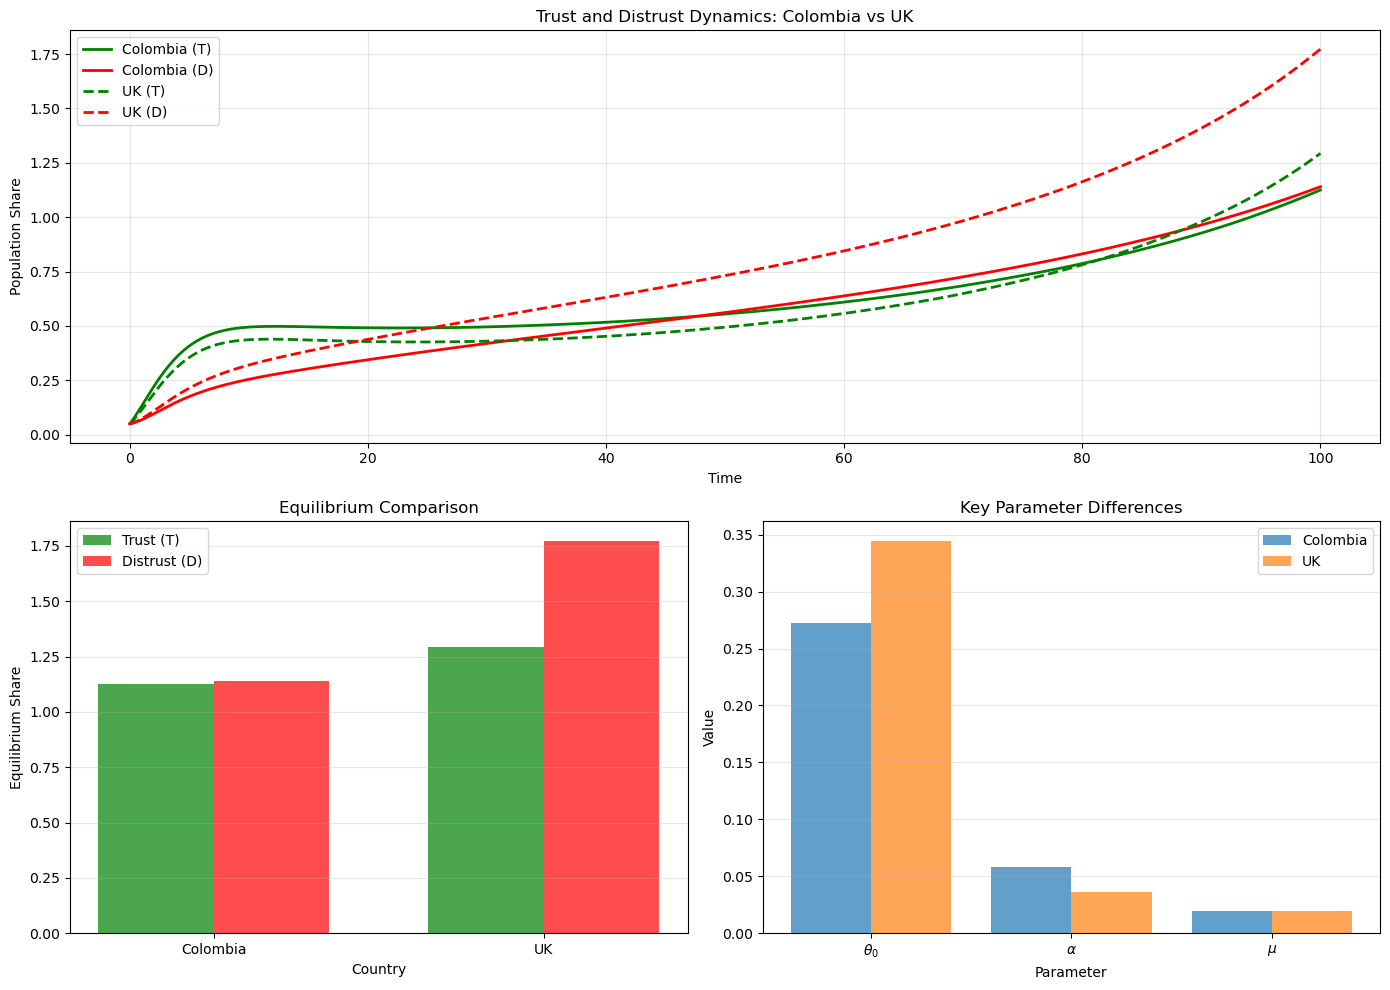


Equilibrium Values:
Colombia: T* = 1.125, D* = 1.140
UK: T* = 1.293, D* = 1.773

SCENARIO 2: Crisis Shock (Temporary θ Spike)

France parameters (trust=47.0%):
  θ₀ = 0.306
  α = 0.048


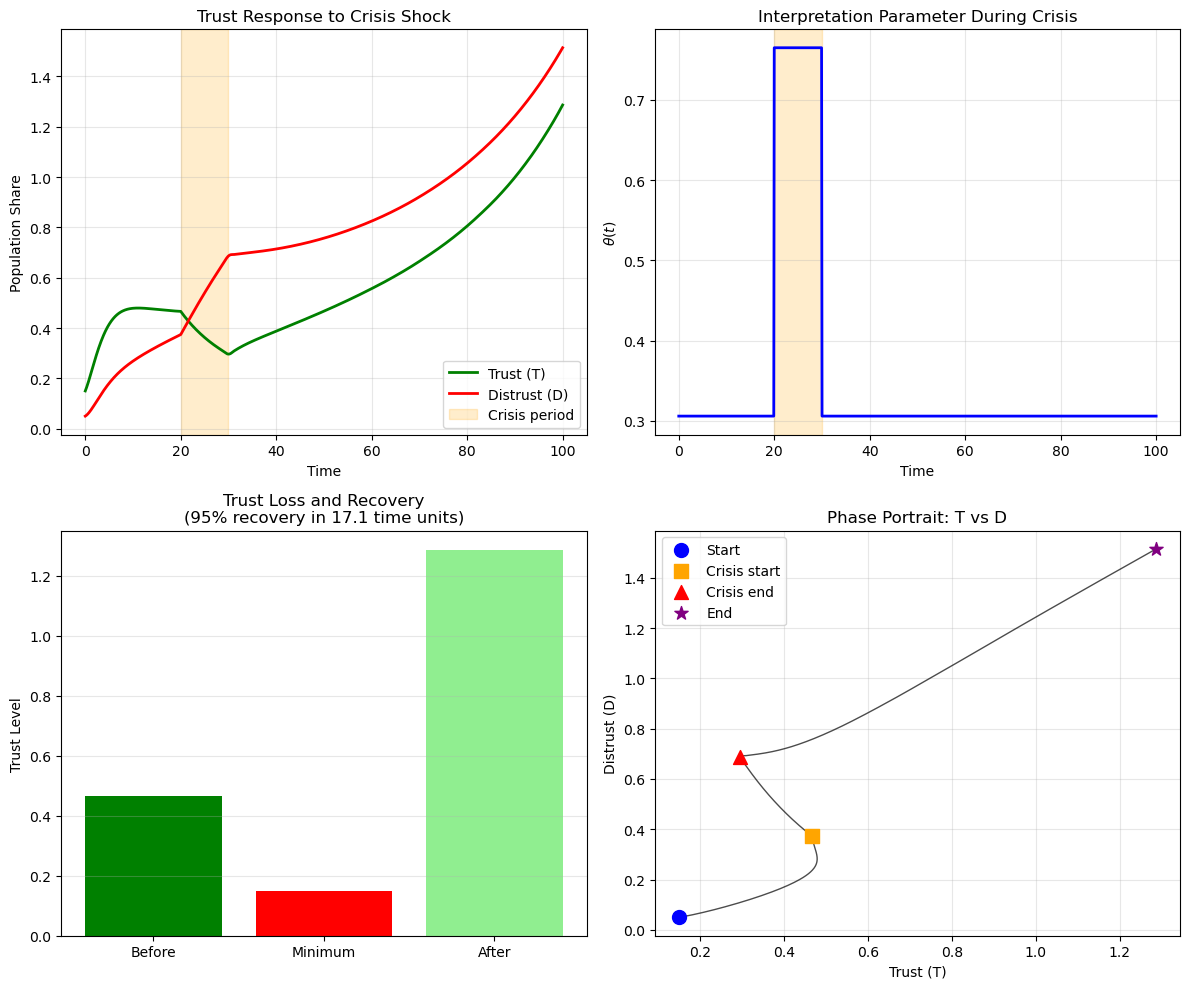


Crisis Impact Analysis:
Trust before crisis: 0.466
Minimum trust during crisis: 0.150
Trust loss: 67.8%
Time to 95% recovery: 17.1 time units

SCENARIO 3: Effect of Distrust Persistence (μ)

USA parameters (trust=50.0%):
  θ₀ = 0.300
  α = 0.050


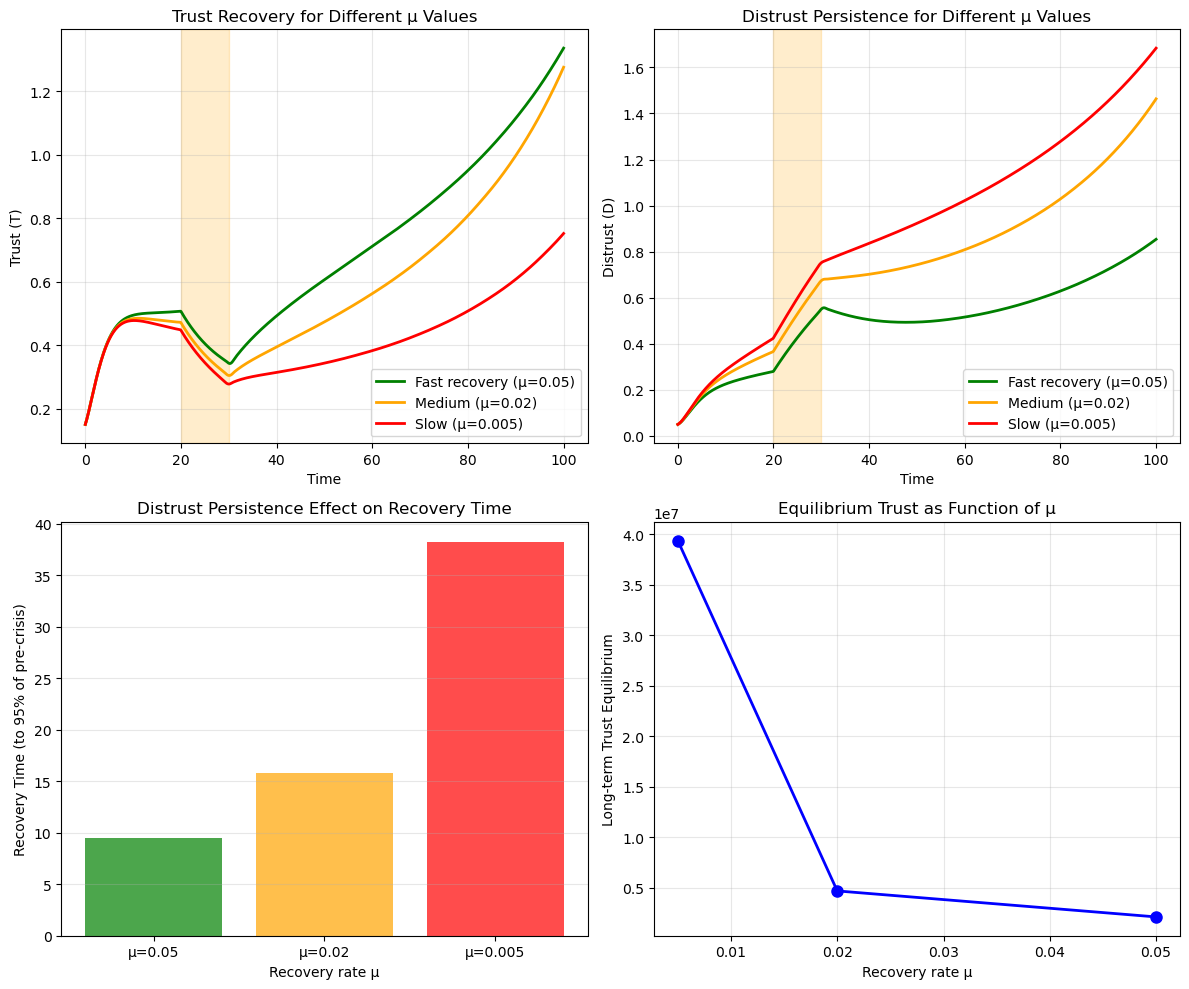


Distrust Persistence Analysis:
μ = 0.050: Recovery time = 9.4, Final T = 2123299.969
μ = 0.020: Recovery time = 15.8, Final T = 4697261.240
μ = 0.005: Recovery time = 38.3, Final T = 39381129.072

SCENARIO 4: OECD Country Comparison

Colombia parameters (trust=63.7%):
  θ₀ = 0.273
  α = 0.058

Poland parameters (trust=62.3%):
  θ₀ = 0.275
  α = 0.057

USA parameters (trust=50.0%):
  θ₀ = 0.300
  α = 0.050

France parameters (trust=47.0%):
  θ₀ = 0.306
  α = 0.048

Germany parameters (trust=37.8%):
  θ₀ = 0.324
  α = 0.043

UK parameters (trust=27.7%):
  θ₀ = 0.345
  α = 0.037


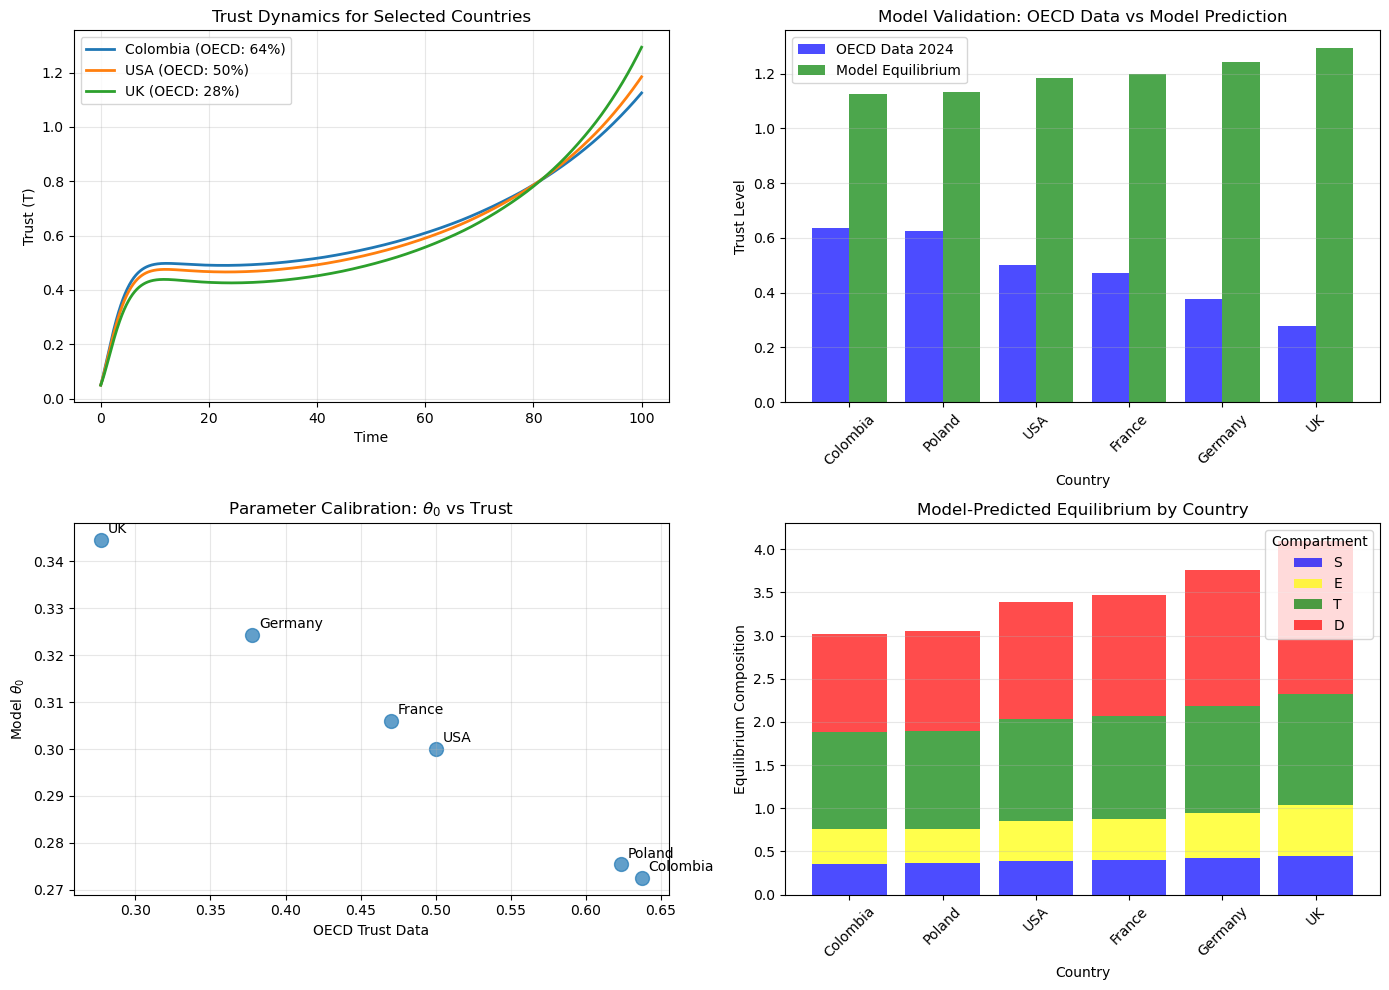


----------------------------------------------------------------------
OECD Country Comparison Summary:
----------------------------------------------------------------------
Country         OECD Trust   Model T    Model D    S+E       
----------------------------------------------------------------------
Colombia        63.7       % 112.5    % 114.0    % 75.5     %
Poland          62.3       % 113.1    % 116.0    % 76.4     %
USA             50.0       % 118.4    % 135.4    % 84.8     %
France          47.0       % 119.8    % 140.5    % 87.0     %
Germany         37.8       % 124.2    % 157.1    % 94.4     %
UK              27.7       % 129.3    % 177.3    % 103.5    %

ALL SIMULATIONS COMPLETED

Generated output files:
1. scenario1_equilibrium.png - Steady state comparison
2. scenario2_crisis_shock.png - Response to θ spike
3. scenario3_distrust_persistence.png - Effect of varying μ
4. scenario4_oecd_comparison.png - OECD country validation


In [ ]:
# ==================== SCENARIO 4: OECD COUNTRY COMPARISON ====================
def scenario_oecd_comparison():
    print("\n" + "="*60)
    print("SCENARIO 4: OECD Country Comparison")
    print("="*60)
    
    # Select 6 representative countries from your data
    countries = {
        'Colombia': 0.637,
        'Poland': 0.623,
        'USA': 0.500,
        'France': 0.470,
        'Germany': 0.378,
        'UK': 0.277
    }
    
    # Run to equilibrium for each country
    equilibria = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Equilibrium trust vs OECD data
    oecd_trust = list(countries.values())
    model_trust = []
    
    for name, trust_data in countries.items():
        params = get_country_params(trust_data, name)
        
        # Start from same initial condition
        y0 = [0.8, 0.1, 0.05, 0.05]
        sol = solve_ivp(
            lambda t, y: media_trust_ode(t, y, params),
            (0, 100), y0, t_eval=np.linspace(0, 100, 1000)
        )
        
        model_trust.append(sol.y[2, -1])
        equilibria[name] = sol.y[:, -1]
        
        # Plot dynamics (first 3 countries)
        if name in ['Colombia', 'USA', 'UK']:
            axes[0,0].plot(sol.t, sol.y[2], linewidth=2, label=f'{name} (OECD: {100*trust_data:.0f}%)')
    
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Trust (T)')
    axes[0,0].set_title('Trust Dynamics for Selected Countries')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Model vs OECD data correlation
    country_names = list(countries.keys())
    x_pos = np.arange(len(country_names))
    
    axes[0,1].bar(x_pos - 0.2, oecd_trust, 0.4, alpha=0.7, label='OECD Data 2024', color='blue')
    axes[0,1].bar(x_pos + 0.2, model_trust, 0.4, alpha=0.7, label='Model Equilibrium', color='green')
    axes[0,1].set_xlabel('Country')
    axes[0,1].set_ylabel('Trust Level')
    axes[0,1].set_title('Model Validation: OECD Data vs Model Prediction')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(country_names, rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Parameter relationships
    theta_vals = [0.4 - 0.2 * t for t in oecd_trust]
    alpha_vals = [0.02 + 0.06 * t for t in oecd_trust]
    
    axes[1,0].scatter(oecd_trust, theta_vals, s=100, alpha=0.7)
    axes[1,0].set_xlabel('OECD Trust Data')
    axes[1,0].set_ylabel(r'Model $\theta_0$')
    axes[1,0].set_title(r'Parameter Calibration: $\theta_0$ vs Trust')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add country labels
    for i, name in enumerate(country_names):
        axes[1,0].annotate(name, (oecd_trust[i], theta_vals[i]), xytext=(5, 5), textcoords='offset points')
    
    # Plot 4: Equilibrium composition
    bottom = np.zeros(len(country_names))
    compartment_colors = ['blue', 'yellow', 'green', 'red']
    compartment_names = ['S', 'E', 'T', 'D']
    
    for i in range(4):
        values = [equilibria[name][i] for name in country_names]
        axes[1,1].bar(country_names, values, 0.8, label=compartment_names[i],color=compartment_colors[i], alpha=0.7, bottom=bottom)
        bottom += values
    
    axes[1,1].set_xlabel('Country')
    axes[1,1].set_ylabel('Equilibrium Composition')
    axes[1,1].set_title('Model-Predicted Equilibrium by Country')
    axes[1,1].legend(title='Compartment')
    axes[1,1].grid(True, alpha=0.3, axis='y')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('scenario4_oecd_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n" + "-"*70)
    print("OECD Country Comparison Summary:")
    print("-"*70)
    print(f"{'Country':<15} {'OECD Trust':<12} {'Model T':<10} {'Model D':<10} {'S+E':<10}")
    print("-"*70)
    
    for name in countries.keys():
        T_eq = equilibria[name][2]
        D_eq = equilibria[name][3]
        S_plus_E = equilibria[name][0] + equilibria[name][1]
        print(f"{name:<15} {100*countries[name]:<11.1f}% {100*T_eq:<9.1f}% {100*D_eq:<9.1f}% {100*S_plus_E:<9.1f}%")

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # Run all scenarios
    scenario_equilibrium()
    scenario_crisis_shock()
    scenario_distrust_persistence()
    scenario_oecd_comparison()
    
    print("\n" + "="*60)
    print("ALL SIMULATIONS COMPLETED")
    print("="*60)
    print("\nGenerated output files:")
    print("1. scenario1_equilibrium.png - Steady state comparison")
    print("2. scenario2_crisis_shock.png - Response to θ spike")
    print("3. scenario3_distrust_persistence.png - Effect of varying μ")
    print("4. scenario4_oecd_comparison.png - OECD country validation")